In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.math as tm
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score

In [2]:
def convert2_zero_one(x):
    
    t = [tf.math.sigmoid(i) for i in x]    
    return t

def cont_bern_log_norm(lam, l_lim=0.49, u_lim=0.51):
    '''
    computes the log normalizing constant of a continuous Bernoulli distribution in a numerically stable way.
    returns the log normalizing constant for lam in (0, l_lim) U (u_lim, 1) and a Taylor approximation in
    [l_lim, u_lim].
    cut_y below might appear useless, but it is important to not evaluate log_norm near 0.5 as tf.where evaluates
    both options, regardless of the value of the condition.
    '''
    
    cut_lam = tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), lam, l_lim * tf.ones_like(lam))
    log_norm = tm.log(tm.abs(2.0 * tm.atanh(1 - 2.0 * cut_lam))) - tm.log(tm.abs(1 - 2.0 * cut_lam))
    taylor = tm.log(2.0) + 4.0 / 3.0 * tm.pow(lam - 0.5, 2) + 104.0 / 45.0 * tm.pow(lam - 0.5, 4)
    return tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), log_norm, taylor)

In [3]:
class StochasticMLP(Model):
    
    def __init__(self, hidden_layer_sizes=[100], n_outputs=10, lr = 0.01):
        super(StochasticMLP, self).__init__()
        self.hidden_layer_sizes = hidden_layer_sizes
        self.fc_layers = [Dense(layer_size) for layer_size in hidden_layer_sizes]
        self.output_layer = Dense(n_outputs)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
        
    def call(self, x):
        
        network = []
        
        for i, layer in enumerate(self.fc_layers):
            
            logits = layer(x)
            x = tfp.distributions.Bernoulli(logits=logits).sample()
            network.append(x)

        final_logits = self.output_layer(x) # initial the weight of output layer
            
        return network
    
    def target_log_prob(self, x, h, y, is_hmc_kernel = False, is_loss = False):
        
        # get current state
        if is_hmc_kernel:
            h_current = tf.split(h, self.hidden_layer_sizes, axis = 1)
        else:    
            h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h]
        h_current = convert2_zero_one(h_current)
        h_previous = [x] + h_current[:-1]
    
        nlog_prob = 0. # negative log probability
        
        if not is_loss:
            for i, (cv, pv, layer) in enumerate(zip(h_current, h_previous, self.fc_layers)):
            
                logits = layer(pv)
                ce = tf.nn.sigmoid_cross_entropy_with_logits(labels = cv, logits = logits)
                ce += cont_bern_log_norm(tf.nn.sigmoid(logits))
            
                nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob
    
    def generate_hmc_kernel(self, x, y, step_size = pow(1000, -1/4)):
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob(x, v, y, is_hmc_kernel = True),
            num_leapfrog_steps = 2,
            step_size = step_size),
            num_adaptation_steps=int(100 * 0.8))
        
        return adaptive_hmc
    
    # new proposing-state method with HamiltonianMonteCarlo
    def propose_new_state_hamiltonian(self, x, h, y, hmc_kernel, is_update_kernel = True):
    
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        h_current = tf.concat(h_current, axis = 1)

        # run the chain (with burn-in)
        num_burnin_steps = 0
        num_results = 1

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = h_current, # may need to be reshaped
            kernel = hmc_kernel,
            trace_fn = None,
            return_final_kernel_results = True)
    
        # Generate new states of chains
        h_state = samples[0][0]
        h_new = tf.split(h_state, self.hidden_layer_sizes, axis = 1) 
        
        # Update the kernel if necesssary
        if is_update_kernel:
            new_step_size = samples[2].new_step_size.numpy()
            ker_new = self.generate_hmc_kernel(x, y, new_step_size)
            return(h_new, ker_new)
        else:
            return h_new
    
    def update_weights(self, x, h, y):
        
        with tf.GradientTape() as tape:
            loss = -1 * tf.reduce_mean(self.target_log_prob(x, h, y))
        
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    
    def get_predictions(self, x):

        logits = 0.0
        for layer in self.fc_layers:
            logits = layer(x)
            x = tm.sigmoid(logits)
        
        logits = self.output_layer(x)
        probs = tm.sigmoid(logits)
        labels = tf.cast(tm.greater(probs, 0.5), tf.int32)

        return probs.numpy(), labels

In [11]:
def hmc(data, epochs):
    '''
    HMC training
    '''
    
    print("Start HMC")
    model = StochasticMLP(hidden_layer_sizes = [size], n_outputs=1, lr = 0.01)
    network = [model.call(images) for images, labels in data]
    kernels = [model.generate_hmc_kernel(images, labels) for images, labels in data]
    
    print("Start HMC Burning")
    burnin = 1000
    tlp = []
    for i in range(burnin):
        
        if(i % 100 == 0): print("Step %d" % i)
        #network, kernels = zip(*[model.propose_new_state_hamiltonian(x, net, y, ker) 
        #           for (x, y), net, ker in zip(data, network, kernels)])
        res = []
        loss = 0.0
        for (x, y), net, ker in zip(train_ds, network, kernels):
            res.append(model.propose_new_state_hamiltonian(x, net, y, ker))
            loss += -1 * tf.reduce_sum(model.target_log_prob(x, net, y))
    
        network, kernels = zip(*res)
        tlp.append(loss / 4)
        
    
    print("Start HMC Training")
    loss_ls = []
    label_acc_ls = []
    prob_acc_ls = []
    start_time = time.time()
    
    probs_0 = []
    probs_1 = []
    probs_2 = []
    probs_3 = []
    for epoch in range(epochs):
    
        for bs, (x, y) in enumerate(data):
        
            # only one mini-batch
            model.update_weights(x, network[bs], y)
            network = [model.propose_new_state_hamiltonian(xx, net, yy, ker, is_update_kernel = False) \
                       for (xx, yy), net, ker in zip(data, network, kernels)]
        
        loss = 0.0
        for bs, (x, y) in enumerate(data):
            loss += -1 * tf.reduce_mean(model.target_log_prob(x, network[bs], y, is_loss = True))
    
        probs, preds = zip(*[model.get_predictions(images) for images, labels in data])
        probs = np.concatenate(probs)
        preds = np.concatenate(preds)
        
        label_acc = accuracy_score(np.concatenate(preds), y_train)
        prob_acc = sum([prob * y + (1 - prob) * (1 - y) for prob, y in zip(probs, y_train)]) / len(y_train)
        
        probs_0.append(probs[0])
        probs_1.append(probs[1])
        probs_2.append(probs[2])
        probs_3.append(probs[3])
        
        loss_ls.append(loss / 4)
        label_acc_ls.append(label_acc)
        prob_acc_ls.append(prob_acc)
    
        print("Epoch %d/%d: - %.4fs/step - loss: %.4f - label accuracy: %.4f - prob accuracy: %.4f" 
            % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), loss_ls[epoch], label_acc, prob_acc))

    train_time = time.time() - start_time
    return tlp, train_time, {"prob_acc": prob_acc_ls, "label_acc": label_acc_ls, "loss": loss_ls}, (probs_0, probs_1, probs_2, probs_3)

In [12]:
x_train = np.array([[0, 0],
           [0, 1],
           [1, 0],
           [1, 1]])
y_train = np.array([[0],
           [1],
           [1],
           [0]])
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(4)

In [13]:
model_size = [32]
for size in model_size:
    
    epochs = 1000
    tlp_burnin_hmc, time_hmc, history_hmc, (probs_0, probs_1, probs_2, probs_3) = hmc(train_ds, epochs)

Start HMC
Start HMC Burning
Step 0
Step 100
Step 200
Step 300
Step 400
Step 500
Step 600
Step 700
Step 800
Step 900
Start HMC Training
Epoch 1/1000: - 0.0415s/step - loss: 0.1696 - label accuracy: 0.5000 - prob accuracy: 0.5001
Epoch 2/1000: - 0.0399s/step - loss: 0.1555 - label accuracy: 0.5000 - prob accuracy: 0.5001
Epoch 3/1000: - 0.0392s/step - loss: 0.1549 - label accuracy: 0.5000 - prob accuracy: 0.5001
Epoch 4/1000: - 0.0389s/step - loss: 0.1438 - label accuracy: 0.5000 - prob accuracy: 0.5001
Epoch 5/1000: - 0.0386s/step - loss: 0.1339 - label accuracy: 0.5000 - prob accuracy: 0.5001
Epoch 6/1000: - 0.0395s/step - loss: 0.1457 - label accuracy: 0.5000 - prob accuracy: 0.5001
Epoch 7/1000: - 0.0396s/step - loss: 0.1329 - label accuracy: 0.5000 - prob accuracy: 0.5001
Epoch 8/1000: - 0.0395s/step - loss: 0.1149 - label accuracy: 0.5000 - prob accuracy: 0.5001
Epoch 9/1000: - 0.0394s/step - loss: 0.1180 - label accuracy: 0.5000 - prob accuracy: 0.5001
Epoch 10/1000: - 0.0393s/ste

Epoch 89/1000: - 0.0424s/step - loss: 0.0252 - label accuracy: 0.5000 - prob accuracy: 0.5050
Epoch 90/1000: - 0.0424s/step - loss: 0.0256 - label accuracy: 0.5000 - prob accuracy: 0.5050
Epoch 91/1000: - 0.0424s/step - loss: 0.0236 - label accuracy: 0.5000 - prob accuracy: 0.5051
Epoch 92/1000: - 0.0424s/step - loss: 0.0230 - label accuracy: 0.5000 - prob accuracy: 0.5052
Epoch 93/1000: - 0.0424s/step - loss: 0.0252 - label accuracy: 0.5000 - prob accuracy: 0.5053
Epoch 94/1000: - 0.0423s/step - loss: 0.0220 - label accuracy: 0.5000 - prob accuracy: 0.5054
Epoch 95/1000: - 0.0424s/step - loss: 0.0320 - label accuracy: 0.5000 - prob accuracy: 0.5055
Epoch 96/1000: - 0.0425s/step - loss: 0.0312 - label accuracy: 0.5000 - prob accuracy: 0.5057
Epoch 97/1000: - 0.0425s/step - loss: 0.0390 - label accuracy: 0.5000 - prob accuracy: 0.5058
Epoch 98/1000: - 0.0425s/step - loss: 0.0381 - label accuracy: 0.5000 - prob accuracy: 0.5059
Epoch 99/1000: - 0.0425s/step - loss: 0.0372 - label accurac

Epoch 176/1000: - 0.0434s/step - loss: 0.0164 - label accuracy: 0.5000 - prob accuracy: 0.5192
Epoch 177/1000: - 0.0435s/step - loss: 0.0118 - label accuracy: 0.5000 - prob accuracy: 0.5193
Epoch 178/1000: - 0.0436s/step - loss: 0.0105 - label accuracy: 0.5000 - prob accuracy: 0.5194
Epoch 179/1000: - 0.0436s/step - loss: 0.0103 - label accuracy: 0.5000 - prob accuracy: 0.5195
Epoch 180/1000: - 0.0436s/step - loss: 0.0123 - label accuracy: 0.5000 - prob accuracy: 0.5196
Epoch 181/1000: - 0.0436s/step - loss: 0.0104 - label accuracy: 0.5000 - prob accuracy: 0.5197
Epoch 182/1000: - 0.0436s/step - loss: 0.0143 - label accuracy: 0.5000 - prob accuracy: 0.5198
Epoch 183/1000: - 0.0436s/step - loss: 0.0113 - label accuracy: 0.5000 - prob accuracy: 0.5199
Epoch 184/1000: - 0.0436s/step - loss: 0.0111 - label accuracy: 0.5000 - prob accuracy: 0.5200
Epoch 185/1000: - 0.0435s/step - loss: 0.0090 - label accuracy: 0.5000 - prob accuracy: 0.5201
Epoch 186/1000: - 0.0435s/step - loss: 0.0089 - la

Epoch 267/1000: - 0.0435s/step - loss: 0.0074 - label accuracy: 0.5000 - prob accuracy: 0.5384
Epoch 268/1000: - 0.0435s/step - loss: 0.0073 - label accuracy: 0.5000 - prob accuracy: 0.5383
Epoch 269/1000: - 0.0435s/step - loss: 0.0072 - label accuracy: 0.5000 - prob accuracy: 0.5382
Epoch 270/1000: - 0.0435s/step - loss: 0.0072 - label accuracy: 0.5000 - prob accuracy: 0.5381
Epoch 271/1000: - 0.0435s/step - loss: 0.0092 - label accuracy: 0.5000 - prob accuracy: 0.5381
Epoch 272/1000: - 0.0435s/step - loss: 0.0091 - label accuracy: 0.5000 - prob accuracy: 0.5381
Epoch 273/1000: - 0.0435s/step - loss: 0.0090 - label accuracy: 0.5000 - prob accuracy: 0.5380
Epoch 274/1000: - 0.0435s/step - loss: 0.0085 - label accuracy: 0.5000 - prob accuracy: 0.5379
Epoch 275/1000: - 0.0435s/step - loss: 0.0088 - label accuracy: 0.5000 - prob accuracy: 0.5378
Epoch 276/1000: - 0.0435s/step - loss: 0.0101 - label accuracy: 0.5000 - prob accuracy: 0.5377
Epoch 277/1000: - 0.0435s/step - loss: 0.0108 - la

Epoch 354/1000: - 0.0434s/step - loss: 0.0137 - label accuracy: 0.5000 - prob accuracy: 0.5387
Epoch 355/1000: - 0.0434s/step - loss: 0.0109 - label accuracy: 0.5000 - prob accuracy: 0.5392
Epoch 356/1000: - 0.0434s/step - loss: 0.0106 - label accuracy: 0.5000 - prob accuracy: 0.5396
Epoch 357/1000: - 0.0434s/step - loss: 0.0104 - label accuracy: 0.5000 - prob accuracy: 0.5401
Epoch 358/1000: - 0.0434s/step - loss: 0.0068 - label accuracy: 0.5000 - prob accuracy: 0.5406
Epoch 359/1000: - 0.0434s/step - loss: 0.0067 - label accuracy: 0.5000 - prob accuracy: 0.5410
Epoch 360/1000: - 0.0434s/step - loss: 0.0112 - label accuracy: 0.5000 - prob accuracy: 0.5414
Epoch 361/1000: - 0.0434s/step - loss: 0.0080 - label accuracy: 0.5000 - prob accuracy: 0.5419
Epoch 362/1000: - 0.0434s/step - loss: 0.0112 - label accuracy: 0.5000 - prob accuracy: 0.5423
Epoch 363/1000: - 0.0434s/step - loss: 0.0116 - label accuracy: 0.5000 - prob accuracy: 0.5427
Epoch 364/1000: - 0.0434s/step - loss: 0.0118 - la

Epoch 441/1000: - 0.0434s/step - loss: 0.0106 - label accuracy: 0.5000 - prob accuracy: 0.5798
Epoch 442/1000: - 0.0434s/step - loss: 0.0103 - label accuracy: 0.5000 - prob accuracy: 0.5806
Epoch 443/1000: - 0.0434s/step - loss: 0.0111 - label accuracy: 0.7500 - prob accuracy: 0.5814
Epoch 444/1000: - 0.0434s/step - loss: 0.0109 - label accuracy: 0.7500 - prob accuracy: 0.5821
Epoch 445/1000: - 0.0434s/step - loss: 0.0069 - label accuracy: 0.7500 - prob accuracy: 0.5827
Epoch 446/1000: - 0.0434s/step - loss: 0.0094 - label accuracy: 0.7500 - prob accuracy: 0.5833
Epoch 447/1000: - 0.0434s/step - loss: 0.0092 - label accuracy: 0.7500 - prob accuracy: 0.5838
Epoch 448/1000: - 0.0434s/step - loss: 0.0090 - label accuracy: 0.7500 - prob accuracy: 0.5843
Epoch 449/1000: - 0.0434s/step - loss: 0.0088 - label accuracy: 0.7500 - prob accuracy: 0.5847
Epoch 450/1000: - 0.0434s/step - loss: 0.0086 - label accuracy: 0.7500 - prob accuracy: 0.5850
Epoch 451/1000: - 0.0434s/step - loss: 0.0084 - la

Epoch 532/1000: - 0.0435s/step - loss: 0.0026 - label accuracy: 0.7500 - prob accuracy: 0.6043
Epoch 533/1000: - 0.0435s/step - loss: 0.0030 - label accuracy: 0.7500 - prob accuracy: 0.6044
Epoch 534/1000: - 0.0435s/step - loss: 0.0029 - label accuracy: 0.7500 - prob accuracy: 0.6045
Epoch 535/1000: - 0.0435s/step - loss: 0.0029 - label accuracy: 0.7500 - prob accuracy: 0.6047
Epoch 536/1000: - 0.0434s/step - loss: 0.0028 - label accuracy: 0.7500 - prob accuracy: 0.6048
Epoch 537/1000: - 0.0434s/step - loss: 0.0031 - label accuracy: 0.7500 - prob accuracy: 0.6049
Epoch 538/1000: - 0.0434s/step - loss: 0.0041 - label accuracy: 0.7500 - prob accuracy: 0.6050
Epoch 539/1000: - 0.0434s/step - loss: 0.0057 - label accuracy: 0.7500 - prob accuracy: 0.6052
Epoch 540/1000: - 0.0434s/step - loss: 0.0038 - label accuracy: 0.7500 - prob accuracy: 0.6052
Epoch 541/1000: - 0.0434s/step - loss: 0.0041 - label accuracy: 0.7500 - prob accuracy: 0.6053
Epoch 542/1000: - 0.0434s/step - loss: 0.0040 - la

Epoch 620/1000: - 0.0434s/step - loss: 0.0023 - label accuracy: 0.5000 - prob accuracy: 0.6133
Epoch 621/1000: - 0.0434s/step - loss: 0.0023 - label accuracy: 0.5000 - prob accuracy: 0.6135
Epoch 622/1000: - 0.0434s/step - loss: 0.0019 - label accuracy: 0.5000 - prob accuracy: 0.6138
Epoch 623/1000: - 0.0434s/step - loss: 0.0012 - label accuracy: 0.5000 - prob accuracy: 0.6142
Epoch 624/1000: - 0.0434s/step - loss: 0.0017 - label accuracy: 0.5000 - prob accuracy: 0.6146
Epoch 625/1000: - 0.0434s/step - loss: 0.0024 - label accuracy: 0.5000 - prob accuracy: 0.6151
Epoch 626/1000: - 0.0434s/step - loss: 0.0067 - label accuracy: 0.5000 - prob accuracy: 0.6155
Epoch 627/1000: - 0.0434s/step - loss: 0.0066 - label accuracy: 0.5000 - prob accuracy: 0.6156
Epoch 628/1000: - 0.0434s/step - loss: 0.0069 - label accuracy: 0.5000 - prob accuracy: 0.6154
Epoch 629/1000: - 0.0434s/step - loss: 0.0066 - label accuracy: 0.5000 - prob accuracy: 0.6150
Epoch 630/1000: - 0.0434s/step - loss: 0.0060 - la

Epoch 708/1000: - 0.0433s/step - loss: 0.0017 - label accuracy: 0.5000 - prob accuracy: 0.6145
Epoch 709/1000: - 0.0433s/step - loss: 0.0017 - label accuracy: 0.5000 - prob accuracy: 0.6144
Epoch 710/1000: - 0.0433s/step - loss: 0.0017 - label accuracy: 0.5000 - prob accuracy: 0.6143
Epoch 711/1000: - 0.0433s/step - loss: 0.0017 - label accuracy: 0.5000 - prob accuracy: 0.6144
Epoch 712/1000: - 0.0433s/step - loss: 0.0016 - label accuracy: 0.5000 - prob accuracy: 0.6145
Epoch 713/1000: - 0.0433s/step - loss: 0.0016 - label accuracy: 0.5000 - prob accuracy: 0.6146
Epoch 714/1000: - 0.0433s/step - loss: 0.0018 - label accuracy: 0.5000 - prob accuracy: 0.6148
Epoch 715/1000: - 0.0434s/step - loss: 0.0016 - label accuracy: 0.5000 - prob accuracy: 0.6151
Epoch 716/1000: - 0.0434s/step - loss: 0.0016 - label accuracy: 0.5000 - prob accuracy: 0.6153
Epoch 717/1000: - 0.0434s/step - loss: 0.0059 - label accuracy: 0.5000 - prob accuracy: 0.6157
Epoch 718/1000: - 0.0434s/step - loss: 0.0058 - la

Epoch 798/1000: - 0.0434s/step - loss: 0.0037 - label accuracy: 0.7500 - prob accuracy: 0.6178
Epoch 799/1000: - 0.0434s/step - loss: 0.0035 - label accuracy: 0.7500 - prob accuracy: 0.6180
Epoch 800/1000: - 0.0434s/step - loss: 0.0035 - label accuracy: 0.7500 - prob accuracy: 0.6183
Epoch 801/1000: - 0.0434s/step - loss: 0.0034 - label accuracy: 0.7500 - prob accuracy: 0.6184
Epoch 802/1000: - 0.0434s/step - loss: 0.0034 - label accuracy: 0.7500 - prob accuracy: 0.6185
Epoch 803/1000: - 0.0434s/step - loss: 0.0034 - label accuracy: 0.7500 - prob accuracy: 0.6185
Epoch 804/1000: - 0.0434s/step - loss: 0.0033 - label accuracy: 0.7500 - prob accuracy: 0.6184
Epoch 805/1000: - 0.0434s/step - loss: 0.0027 - label accuracy: 0.7500 - prob accuracy: 0.6184
Epoch 806/1000: - 0.0434s/step - loss: 0.0027 - label accuracy: 0.7500 - prob accuracy: 0.6183
Epoch 807/1000: - 0.0434s/step - loss: 0.0185 - label accuracy: 0.7500 - prob accuracy: 0.6182
Epoch 808/1000: - 0.0434s/step - loss: 0.0182 - la

Epoch 888/1000: - 0.0435s/step - loss: 0.0038 - label accuracy: 0.5000 - prob accuracy: 0.5987
Epoch 889/1000: - 0.0435s/step - loss: 0.0037 - label accuracy: 0.5000 - prob accuracy: 0.5996
Epoch 890/1000: - 0.0435s/step - loss: 0.0037 - label accuracy: 0.5000 - prob accuracy: 0.6005
Epoch 891/1000: - 0.0435s/step - loss: 0.0034 - label accuracy: 0.5000 - prob accuracy: 0.6015
Epoch 892/1000: - 0.0435s/step - loss: 0.0034 - label accuracy: 0.5000 - prob accuracy: 0.6026
Epoch 893/1000: - 0.0435s/step - loss: 0.0035 - label accuracy: 0.5000 - prob accuracy: 0.6037
Epoch 894/1000: - 0.0435s/step - loss: 0.0044 - label accuracy: 0.5000 - prob accuracy: 0.6049
Epoch 895/1000: - 0.0435s/step - loss: 0.0044 - label accuracy: 0.5000 - prob accuracy: 0.6060
Epoch 896/1000: - 0.0435s/step - loss: 0.0043 - label accuracy: 0.5000 - prob accuracy: 0.6071
Epoch 897/1000: - 0.0435s/step - loss: 0.0033 - label accuracy: 0.5000 - prob accuracy: 0.6082
Epoch 898/1000: - 0.0435s/step - loss: 0.0032 - la

Epoch 978/1000: - 0.0435s/step - loss: 0.0014 - label accuracy: 0.7500 - prob accuracy: 0.6478
Epoch 979/1000: - 0.0435s/step - loss: 0.0014 - label accuracy: 0.7500 - prob accuracy: 0.6487
Epoch 980/1000: - 0.0435s/step - loss: 0.0014 - label accuracy: 0.7500 - prob accuracy: 0.6495
Epoch 981/1000: - 0.0435s/step - loss: 0.0014 - label accuracy: 0.7500 - prob accuracy: 0.6504
Epoch 982/1000: - 0.0435s/step - loss: 0.0014 - label accuracy: 0.7500 - prob accuracy: 0.6513
Epoch 983/1000: - 0.0435s/step - loss: 0.0013 - label accuracy: 1.0000 - prob accuracy: 0.6521
Epoch 984/1000: - 0.0435s/step - loss: 0.0028 - label accuracy: 1.0000 - prob accuracy: 0.6530
Epoch 985/1000: - 0.0435s/step - loss: 0.0027 - label accuracy: 1.0000 - prob accuracy: 0.6537
Epoch 986/1000: - 0.0435s/step - loss: 0.0027 - label accuracy: 1.0000 - prob accuracy: 0.6544
Epoch 987/1000: - 0.0435s/step - loss: 0.0026 - label accuracy: 1.0000 - prob accuracy: 0.6549
Epoch 988/1000: - 0.0435s/step - loss: 0.0026 - la

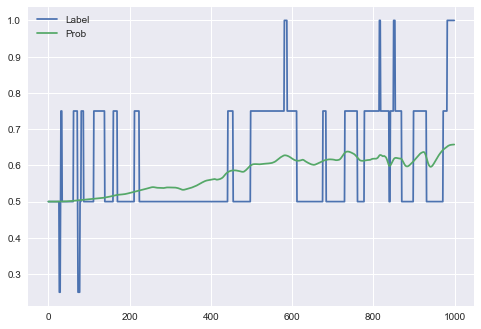

In [14]:
plt.plot(list(range(epochs)), history_hmc['label_acc'], label = 'Label')
plt.plot(list(range(epochs)), history_hmc['prob_acc'], label = 'Prob')
plt.legend()
plt.show()

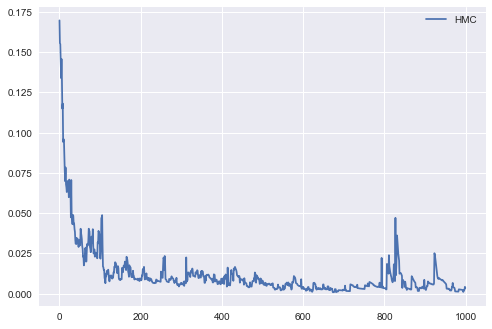

In [15]:
plt.plot(list(range(epochs)), history_hmc['loss'], label = 'HMC')
plt.legend()
plt.show()

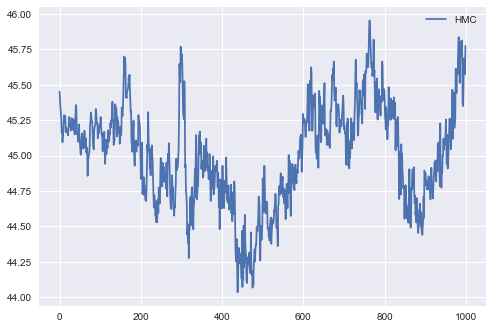

In [16]:
plt.plot(list(range(1000)), tlp_burnin_hmc, label = 'HMC')
plt.legend()
plt.show()

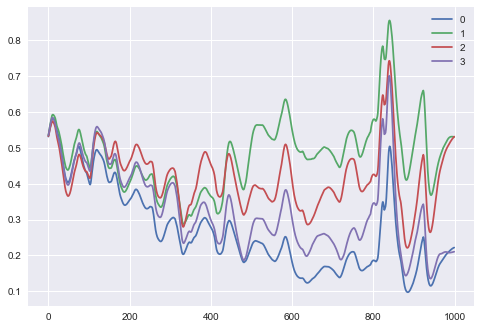

In [17]:
plt.style.use('seaborn')
plt.plot(list(range(epochs)), probs_0, label = '0')
plt.plot(list(range(epochs)), probs_1, label = '1')
plt.plot(list(range(epochs)), probs_2, label = '2')
plt.plot(list(range(epochs)), probs_3, label = '3')
plt.legend()

plt.show()